In [1]:
from tqdm import tqdm
from glob import glob
import shutil
import os
import cv2
import numpy as np
import skimage.measure
import random
import xml.etree.ElementTree as ET

from skimage.feature import greycomatrix, greycoprops
from skimage import data
import matplotlib.pyplot as plt

from IPython.display import *
def show(img):
    cv2.imwrite('test.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), 50])
    display(Image('test.jpg'))

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [108]:
fnames = [x for x in glob('/home/ypw/data/xuelang/xuelang_round1_train*/*/*.jpg') if '正常' not in x]

In [121]:
# /home/ypw/data/xuelang/xuelang_round1_train_part2_20180705/擦洞/J01_2018.06.26 13_41_06.jpg

fname = random.choice(fnames)
print(fname)
img = gray(cv2.imread(fname))
img = cv2.equalizeHist(img)

/home/ypw/data/xuelang/xuelang_round1_train_part3_20180709/毛洞/J01_2018.06.17 13_54_48.jpg


In [122]:
xml_fname = fname.replace('.jpg', '.xml')
tree = ET.parse(xml_fname)
for ob in tree.findall('object'):
    bbox = ob.find('bndbox')
    tagname = ob.find('name').text
    x1, y1, x2, y2 = [int(x.text) for x in bbox.getchildren()]
    break

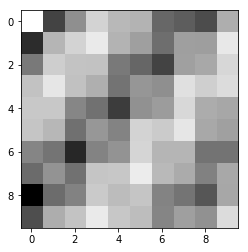

In [123]:
b = 10
a = b
w = 128
d = np.zeros((b, a, 4))

for j in range(b):
    for i in range(a):
        dx = i
        dy = j
        img1 = img[y2:y2+w,x2:x2+w]
        img2 = img[y2+dy:y2+w+dy,x2+dx:x2+w+dx]
        delta = np.abs(img1.astype('float') - img2.astype('float'))
        
        d[j,i] = delta.min() , delta.mean(), delta.max(), delta.std()

d[0,0] = d.mean()
plt.imshow(d[:,:,1], cmap='gray')

In [124]:
dd = d[:,:,1]
dy, dx = np.unravel_index(dd.argmin(), dd.shape)
dy, dx, dd[dy, dx]

(8, 0, 43.23065185546875)

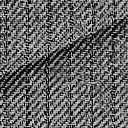

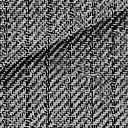

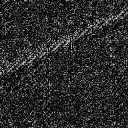

37.240686563981676

In [125]:
img1 = img[y2:y2+w,x2:x2+w]
img2 = img[y2+dy:y2+w+dy,x2+dx:x2+w+dx]
delta = np.abs(img1.astype('float') - img2.astype('float'))
show(img1)
show(img2)
show(delta)
delta.std()

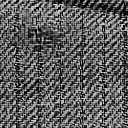

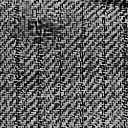

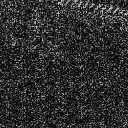

37.75678396170832

In [126]:
xml_fname = fname.replace('.jpg', '.xml')
tree = ET.parse(xml_fname)
for ob in tree.findall('object'):
    bbox = ob.find('bndbox')
    tagname = ob.find('name').text
    x1, y1, x2, y2 = [int(x.text) for x in bbox.getchildren()]
    break

img1 = img[y1:y1+w,x1:x1+w]
img2 = img[y1+dy:y1+w+dy,x1+dx:x1+w+dx]
delta = np.abs(img1.astype('float') - img2.astype('float'))

show(img1)
show(img2)
show(delta)
delta.std()

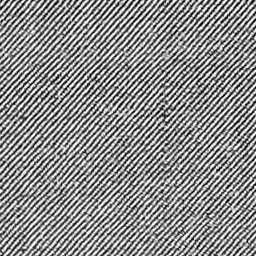

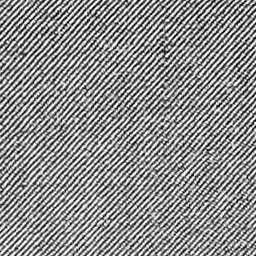

272

In [17]:
height, width = img.shape
size = 128
stride = 64

imgs = []
for j, x1, in enumerate(range(x2, width - size + stride, stride)):
    for i, y1 in enumerate(range(y2, height - size + stride, stride)):
        imgs.append(img[y1:y1+w,x1:x1+w])
show(imgs[0])
show(imgs[1])
len(imgs)

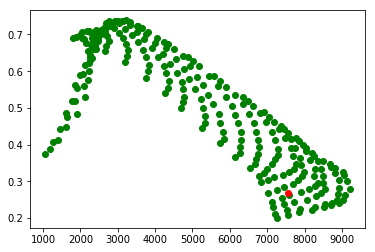

In [12]:
xs = []
ys = []
for i in [img1] + imgs:
    glcm = greycomatrix(i, [5], [0], 256, symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'contrast')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])

plt.plot(xs[1:], ys[1:], 'go')
plt.plot(xs[:1], ys[:1], 'ro')

In [7]:
height, width = img.shape
size = 128
stride = 64
features = ['contrast', 'correlation']

glcms = np.zeros((len(range(0, height - size + stride, stride)), 
                 len(range(0, width - size + stride, stride)), 
                 len(features))
                )

with tqdm(range(0, width - size + stride, stride)) as pbar:
    for j, x1 in enumerate(pbar):
        for i, y1 in enumerate(range(0, height - size + stride, stride)):
            x2 = x1 + size
            y2 = y1 + size

            if x1 < 0:
                x1 = 0
                x2 = size

            if x2 > width:
                x1 = width - size
                x2 = width

            if y1 < 0:
                y1 = 0
                y2 = size

            if y2 > height:
                y1 = height - size
                y2 = height

            patch = img[y1:y2, x1:x2]
            glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
            for k, feature in enumerate(features):
                glcms[i, j, k] = greycoprops(glcm, feature)[0, 0]

100%|██████████| 39/39 [00:02<00:00, 19.11it/s]


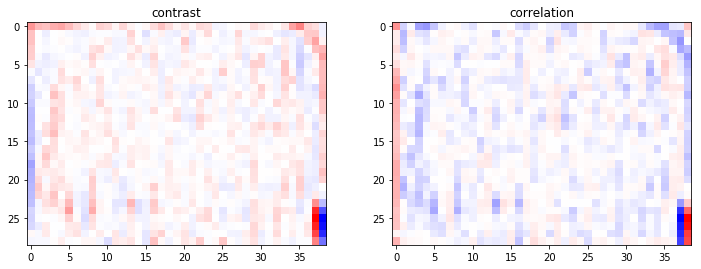

In [8]:
plt.figure(figsize=(12, 9))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    plt.title(feature)
    
    a = glcms[:,:,i]
    a = cv2.Laplacian(a, cv2.CV_64F)
    a[a<0] = -a[a<0] / a[a<0].min()
    a[a>0] = a[a>0] / a[a>0].max()
    plt.imshow(a, cmap='bwr')